In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import seaborn as sns

# FIA 

In [16]:
# Reading the data file - FIATreeSpeciesCode_pft.csv
df_fia_species = pd.read_csv("./FIA/FIATreeSpeciesCode_pft.csv", sep=";")
df_fia_species_imp = df_fia_species[['SPCD', 'COMMON_NAME', 'PFT']].copy()

# Reading the data file - CA_TREE.csv
df_fia_tree = pd.read_csv("./FIA/CA_TREE.csv", low_memory=False)
df_fia_tree_imp = df_fia_tree[['STATECD', 'PLOT', 'PLT_CN', 'UNITCD', 'COUNTYCD', 'TREE', 'SPCD', 'DIA', 'HT', 'CR']].copy()

# Reading the data file - CA_PLOT.csv
df_fia_plot = pd.read_csv("./FIA/CA_PLOT.csv", low_memory=False)
df_fia_plot_imp = df_fia_plot[['PLOT_STATUS_CD', 'LAT', 'LON', 'ELEV', 'ECOSUBCD', 'CN']].copy()

# Create a dictionary mapping SPCD to COMMON_NAME
fia_ref_species_table = pd.read_csv('./FIA/REF_SPECIES.csv')
spcd_to_common_name = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['COMMON_NAME']))

# Analyzing the shape
print(df_fia_species_imp.shape)
print(df_fia_tree_imp.shape)
print(df_fia_plot_imp.shape)


# Merging the FIA Species and FIA tree based on SPCD
df_fia = df_fia_tree_imp.merge(df_fia_species_imp, on="SPCD", how="left")
# Merging the resulting FIA dataset and FIA plot based on PLOT_CN and CN
df_fia = df_fia.merge(df_fia_plot_imp, left_on="PLT_CN", right_on="CN", how="left")
print(df_fia.shape)
df_fia.head()
df_fia['BasalA'] = (np.pi * df_fia['DIA']**2) / (4 * 144)
df_fia_ckpt1 = df_fia[['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'SPCD', 'ECOSUBCD', 'PFT']].copy()
df_fia_ckpt1.head()

df_fia_ckpt1.isna().sum()

df_fia_ckpt2 = df_fia_ckpt1.dropna(axis=0).copy()
print(df_fia_ckpt2.shape)
df_fia_ckpt2.head()


# Converting from inches to cm
df_fia_ckpt2['DIA_cm'] = df_fia_ckpt2['DIA'] * 2.54
df_fia_ckpt2.head()

# Define the ECOSUBCDs to keep
ecosubcd_keep = ['M261Ep', '261Ba', 'M261Em', '263Am', 'M261Ej']

# Filter the DataFrame
df_fia_ckpt2_filtered = df_fia_ckpt2[df_fia_ckpt2['ECOSUBCD'].isin(ecosubcd_keep)]
# Shuffle the filtered DataFrame
df_fia_ckpt2_filtered_shuffled = df_fia_ckpt2_filtered.sample(frac=1, random_state=42).reset_index(drop=True)

df_fia_ecosubcd = df_fia_ckpt2_filtered_shuffled['ECOSUBCD']

df_encoded = pd.get_dummies(df_fia_ckpt2_filtered_shuffled, columns=['ECOSUBCD'])
df_encoded = df_encoded.drop(['ECOSUBCD_M261Ep'], axis=1)
df_encoded['ECOSUBCD'] = df_fia_ecosubcd

replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_encoded['PFT'] = df_encoded['PFT'].replace(replace_dict)
df_encoded = df_encoded[df_encoded['PFT'] != 'Broadleaf']
df_encoded['PFT'].value_counts()


df_ref_species = pd.read_csv('./FIA/REF_SPECIES.csv')
df_ref_species = df_ref_species[['SPCD', 'GENUS', 'SPECIES', 'COMMON_NAME']].copy()
print(f"Shape: {df_ref_species.shape}")
df_ref_species.head()
df_encoded_fia = df_encoded.copy()
df_encoded_fia = df_encoded_fia.merge(df_ref_species, on="SPCD", how="left")
print(f"Shape: {df_encoded_fia.shape}")
df_encoded_fia['GENUS'].value_counts()
len(df_encoded_fia['GENUS'].unique())
# List of genera to keep
genera_to_keep = ['Abies', 'Calocedrus', 'Salix', 'Pinus', 'Cornus', 'Populus',
                  'Quercus', 'Sequoiadendron', 'Acer', 'Pseudotsuga', 'Arbutus',
                  'Notholicarpos']

# Filter the DataFrame
df_encoded_fia = df_encoded_fia[df_encoded_fia["GENUS"].isin(genera_to_keep)].copy()
df_encoded_fia['SPECIES'].value_counts()
df_encoded_fia['PFT'] = df_encoded_fia['PFT'].astype('category')
df_encoded_fia.head()

(459, 3)
(427519, 10)
(42036, 6)
(427519, 18)
(389048, 8)
Shape: (2677, 4)
Shape: (23724, 16)


,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine


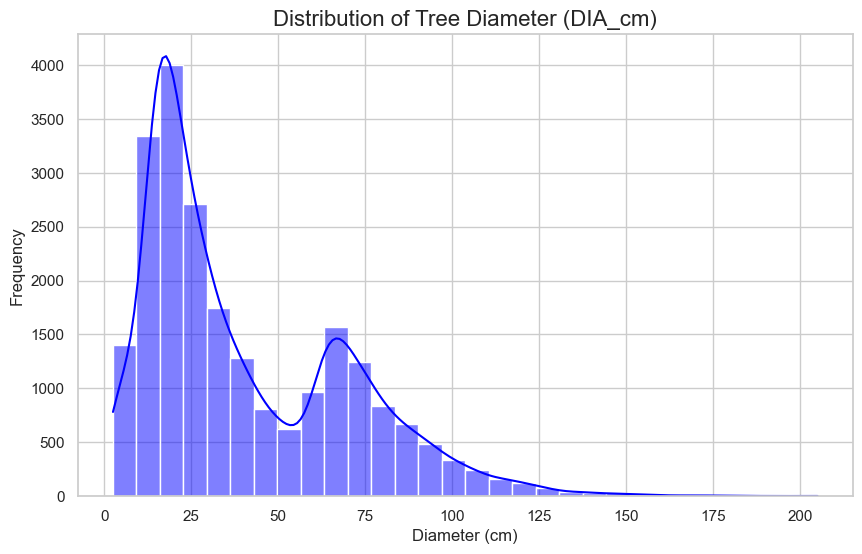

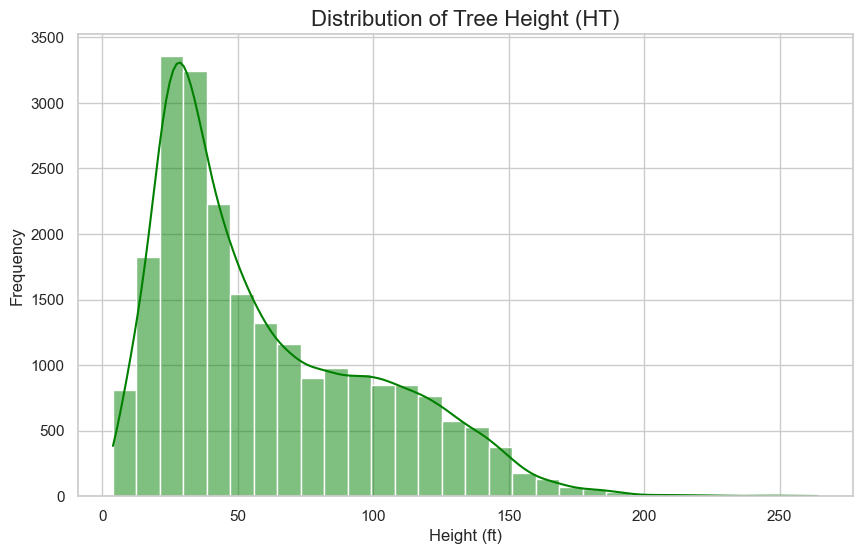

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/498571824.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_encoded_fia, x='PFT', order=df_encoded_fia['PFT'].value_counts().index, palette='viridis')


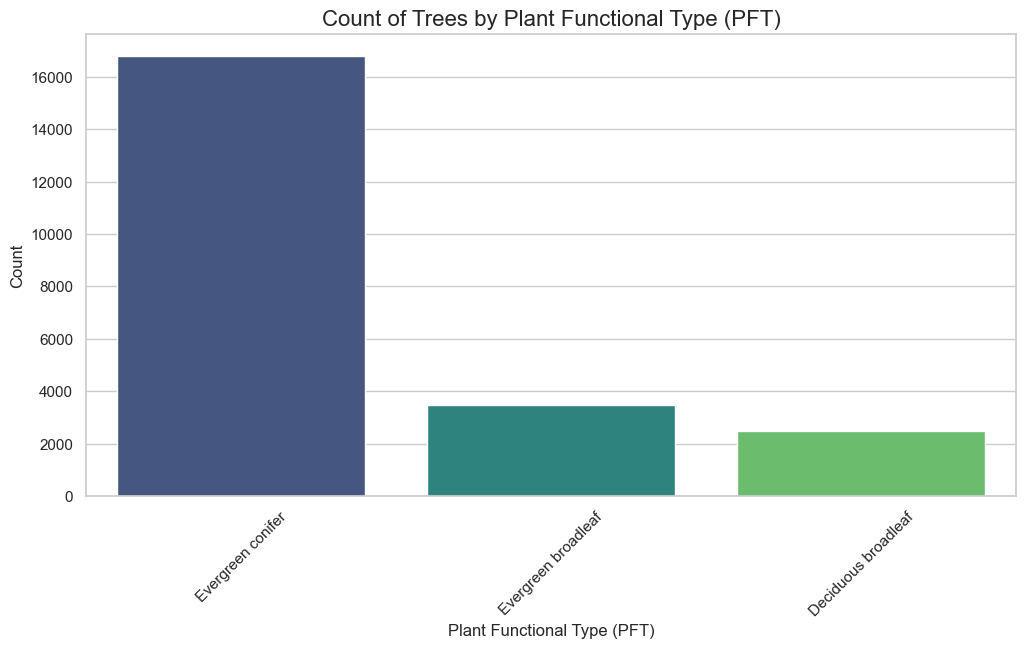

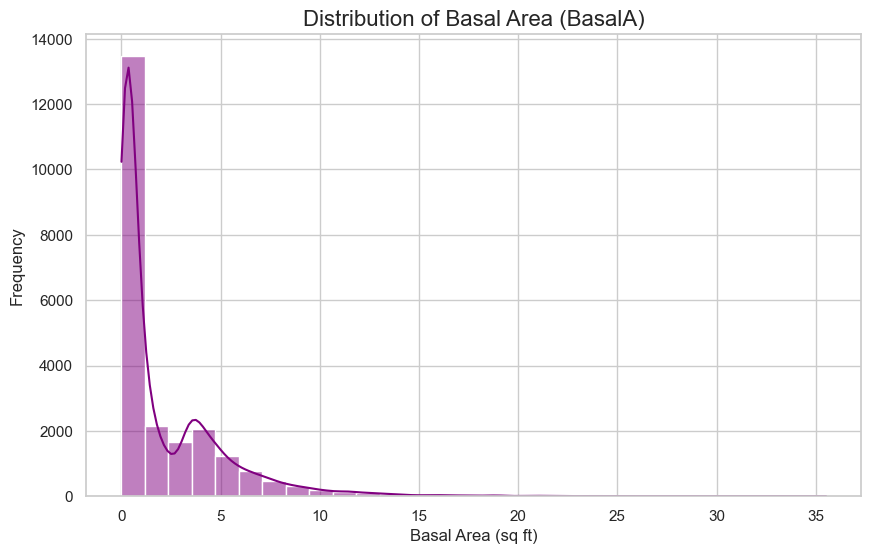

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/498571824.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_encoded_fia[df_encoded_fia['GENUS'].isin(top_genera)], x='GENUS', palette='coolwarm')


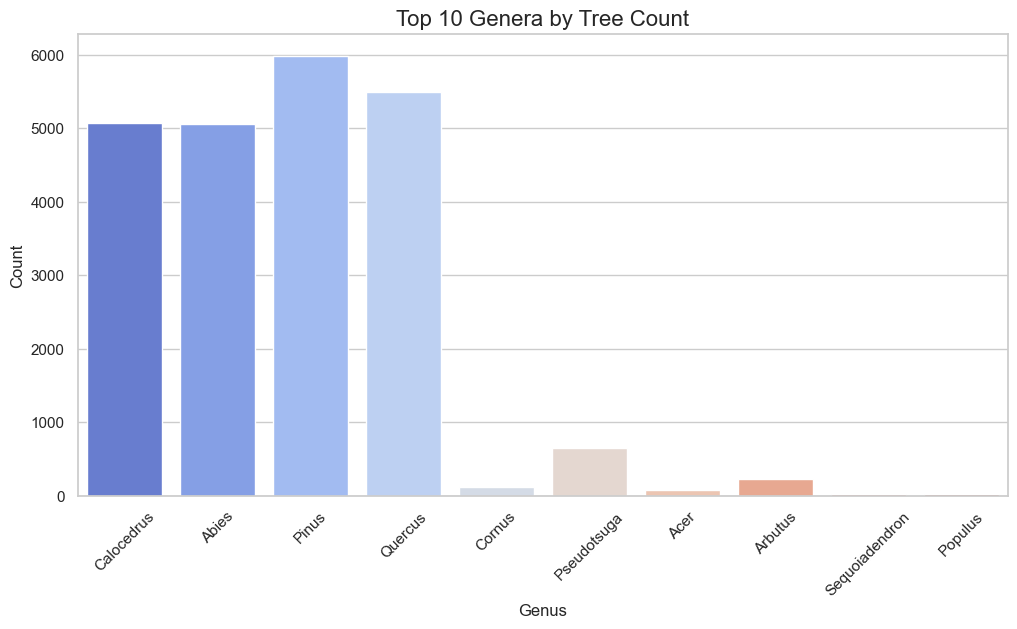

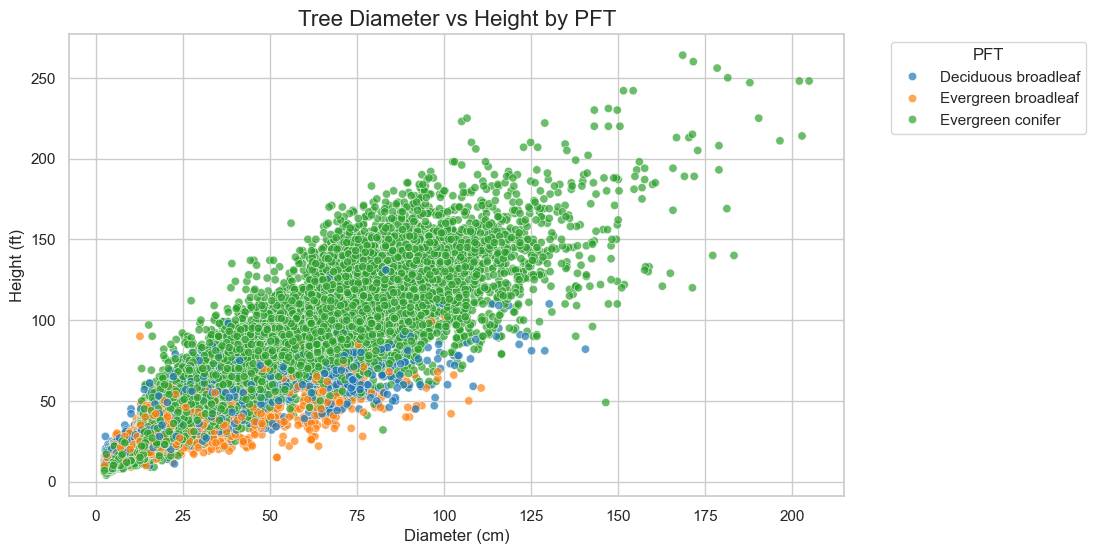

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/498571824.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_encoded_fia, x='PFT', y='DIA_cm', palette='Set2')


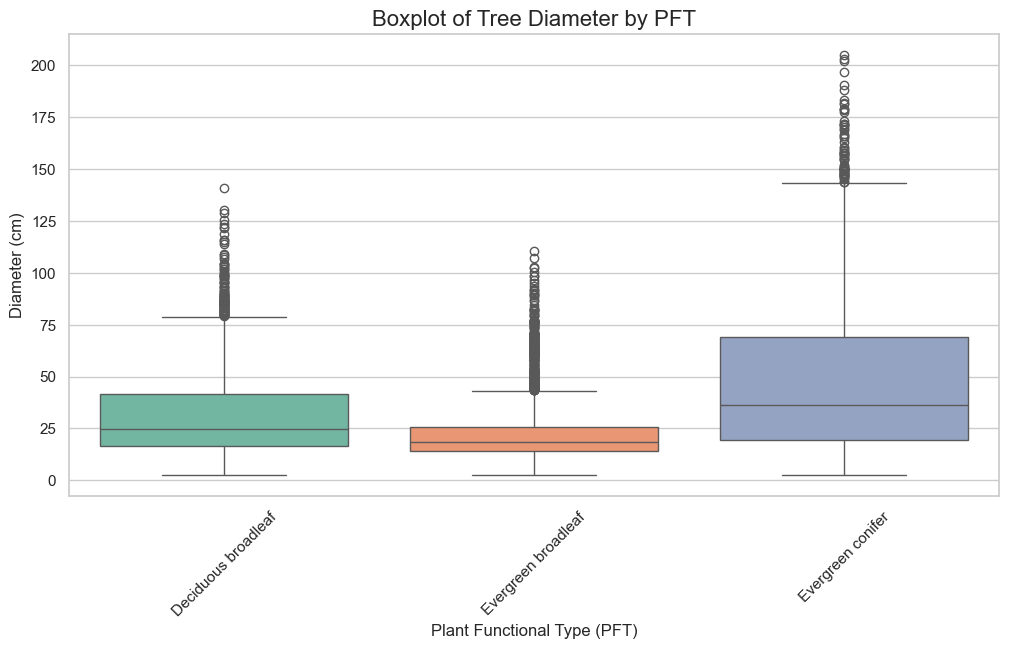

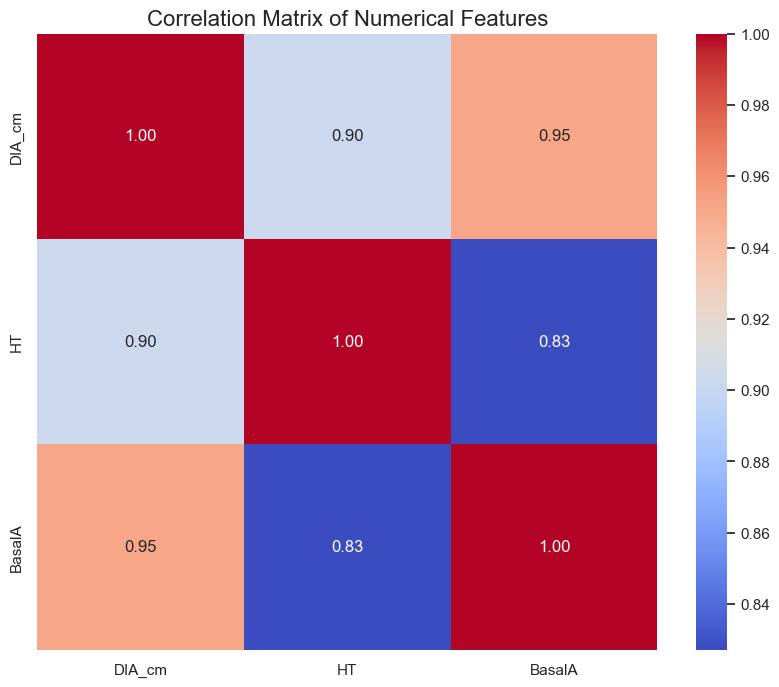

In [ ]:
# Set a style for the plots
sns.set(style="whitegrid")

# 1. Distribution of Diameter (DIA_cm)
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded_fia['DIA_cm'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tree Diameter (DIA_cm)', fontsize=16)
plt.xlabel('Diameter (cm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 2. Distribution of Tree Height (HT)
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded_fia['HT'], bins=30, kde=True, color='green')
plt.title('Distribution of Tree Height (HT)', fontsize=16)
plt.xlabel('Height (ft)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 3. Count of Trees by PFT
plt.figure(figsize=(12, 6))
sns.countplot(data=df_encoded_fia, x='PFT', order=df_encoded_fia['PFT'].value_counts().index, palette='viridis')
plt.title('Count of Trees by Plant Functional Type (PFT)', fontsize=16)
plt.xlabel('Plant Functional Type (PFT)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 4. Distribution of Basal Area (BasalA)
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded_fia['BasalA'], bins=30, kde=True, color='purple')
plt.title('Distribution of Basal Area (BasalA)', fontsize=16)
plt.xlabel('Basal Area (sq ft)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 5. Count of Trees by Genus
plt.figure(figsize=(12, 6))
top_genera = df_encoded_fia['GENUS'].value_counts().head(10).index
sns.countplot(data=df_encoded_fia[df_encoded_fia['GENUS'].isin(top_genera)], x='GENUS', palette='coolwarm')
plt.title('Top 10 Genera by Tree Count', fontsize=16)
plt.xlabel('Genus', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 6. Scatter plot of Diameter vs Height
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded_fia, x='DIA_cm', y='HT', hue='PFT', palette='tab10', alpha=0.7)
plt.title('Tree Diameter vs Height by PFT', fontsize=16)
plt.xlabel('Diameter (cm)', fontsize=12)
plt.ylabel('Height (ft)', fontsize=12)
plt.legend(title='PFT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 7. Boxplot of Diameter by PFT
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_encoded_fia, x='PFT', y='DIA_cm', palette='Set2')
plt.title('Boxplot of Tree Diameter by PFT', fontsize=16)
plt.xlabel('Plant Functional Type (PFT)', fontsize=12)
plt.ylabel('Diameter (cm)', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 8. Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
corr_matrix = df_encoded_fia[['DIA_cm', 'HT', 'BasalA']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()

<Figure size 1200x1000 with 0 Axes>

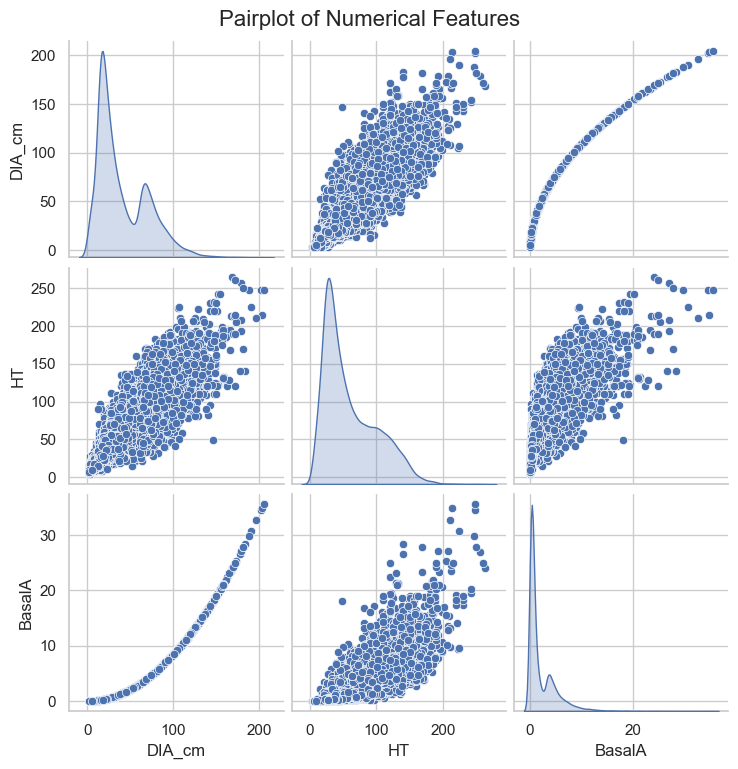

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/1831545556.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_encoded_fia, x='ECOSUBCD', order=df_encoded_fia['ECOSUBCD'].value_counts().index, palette='magma')


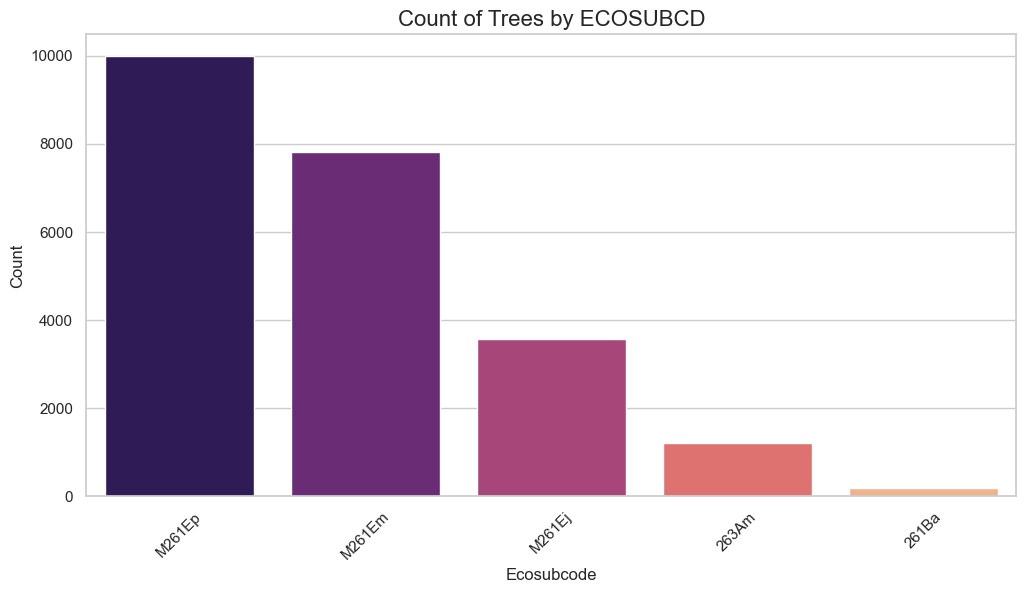

In [ ]:
# Pairplot of Numerical Features
plt.figure(figsize=(12, 10))
sns.pairplot(df_encoded_fia[['DIA_cm', 'HT', 'BasalA']], diag_kind='kde')
plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=16)
plt.show()

# Count of Trees by ECOSUBCD
plt.figure(figsize=(12, 6))
sns.countplot(data=df_encoded_fia, x='ECOSUBCD', order=df_encoded_fia['ECOSUBCD'].value_counts().index, palette='magma')
plt.title('Count of Trees by ECOSUBCD', fontsize=16)
plt.xlabel('Ecosubcode', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()


In [19]:
df_encoded_fia.columns

Index(['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'SPCD', 'PFT', 'DIA_cm',
       'ECOSUBCD_261Ba', 'ECOSUBCD_263Am', 'ECOSUBCD_M261Ej',
       'ECOSUBCD_M261Em', 'ECOSUBCD', 'GENUS', 'SPECIES', 'COMMON_NAME'],
      dtype='object')

In [20]:
df_encoded_fia

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23718,15.1,93.0,1.243602,36.791094,-118.966081,15.0,Evergreen conifer,38.354,False,False,False,False,M261Ep,Abies,concolor,white fir
23719,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,M261Em,Pinus,ponderosa,ponderosa pine
23720,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,M261Ep,Quercus,kelloggii,California black oak
23721,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar


/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/2836117344.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='GENUS', data=df, order=df['GENUS'].value_counts().index, palette='tab20')


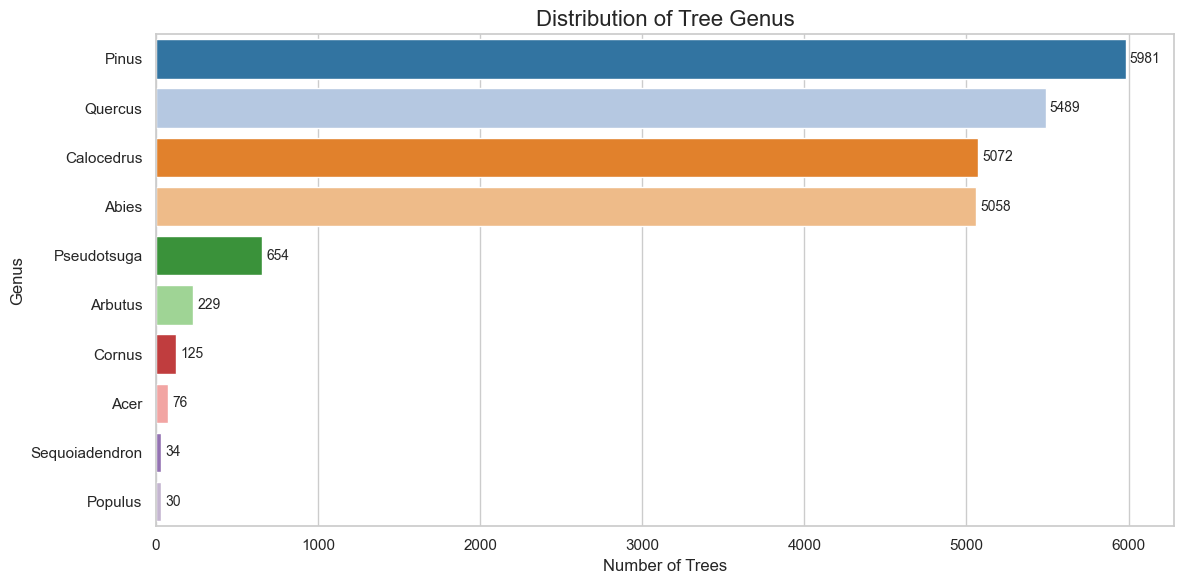

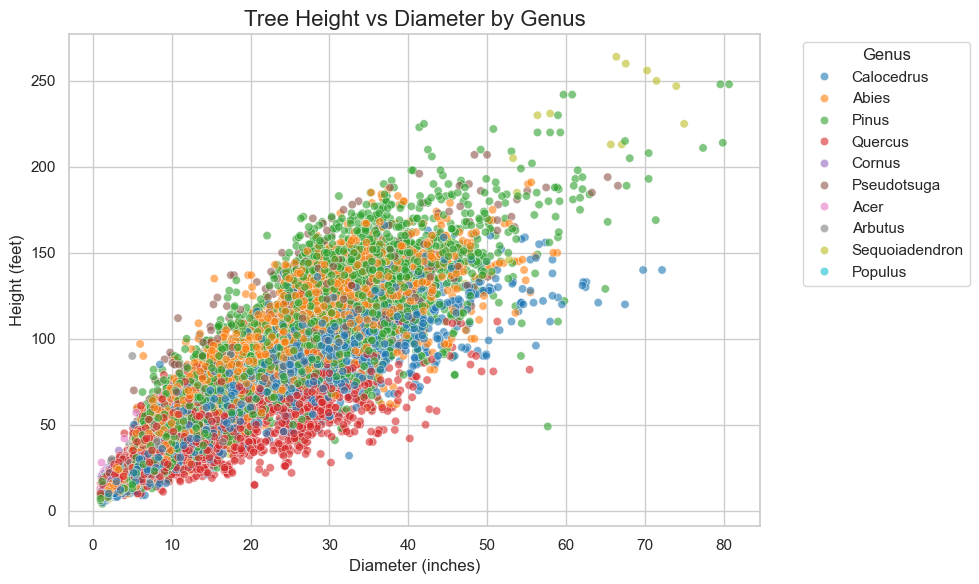

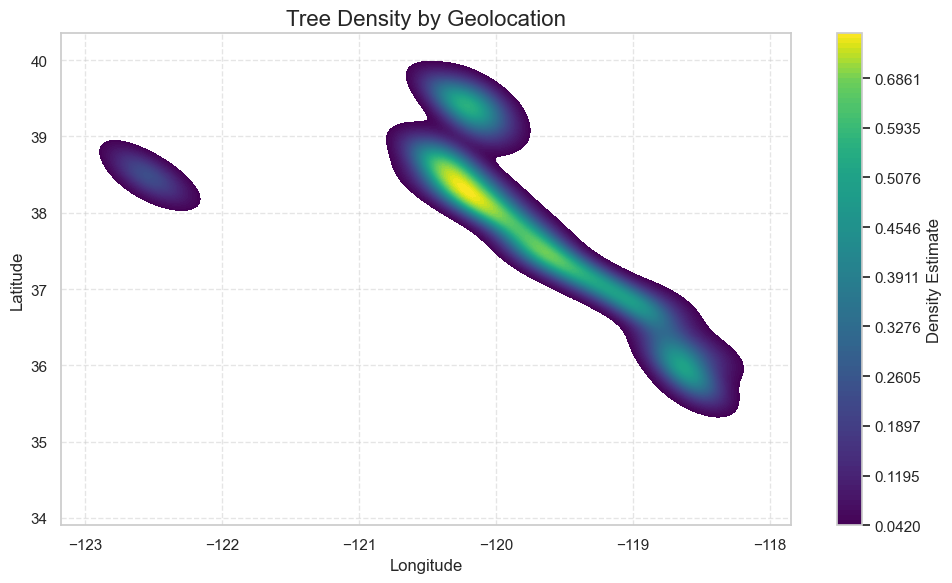

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/2836117344.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_ecos.values, y=top_ecos.index, palette='coolwarm')


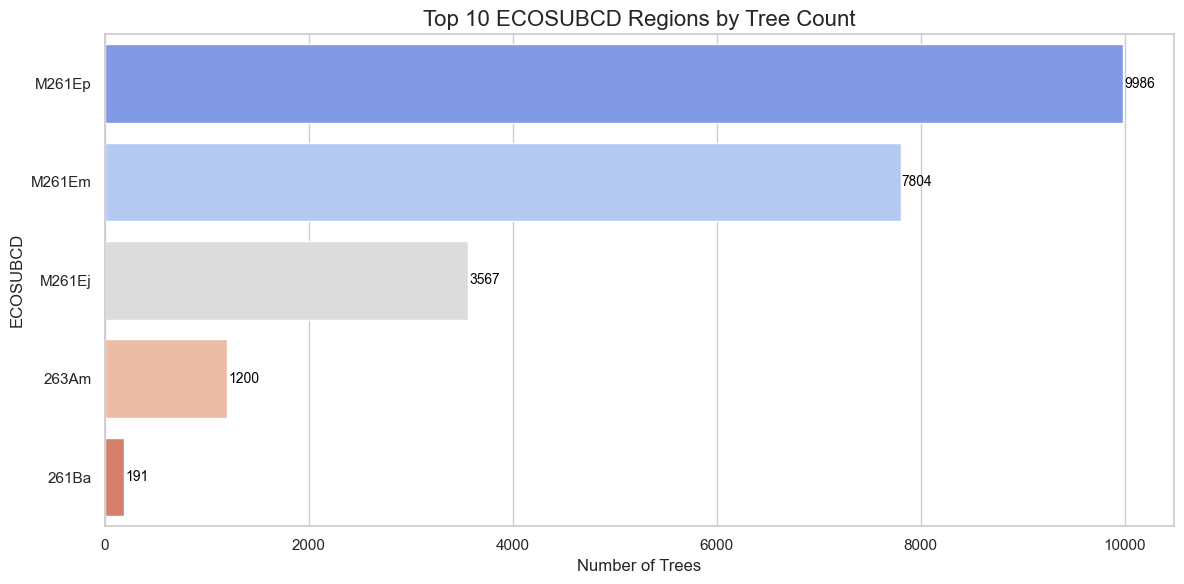

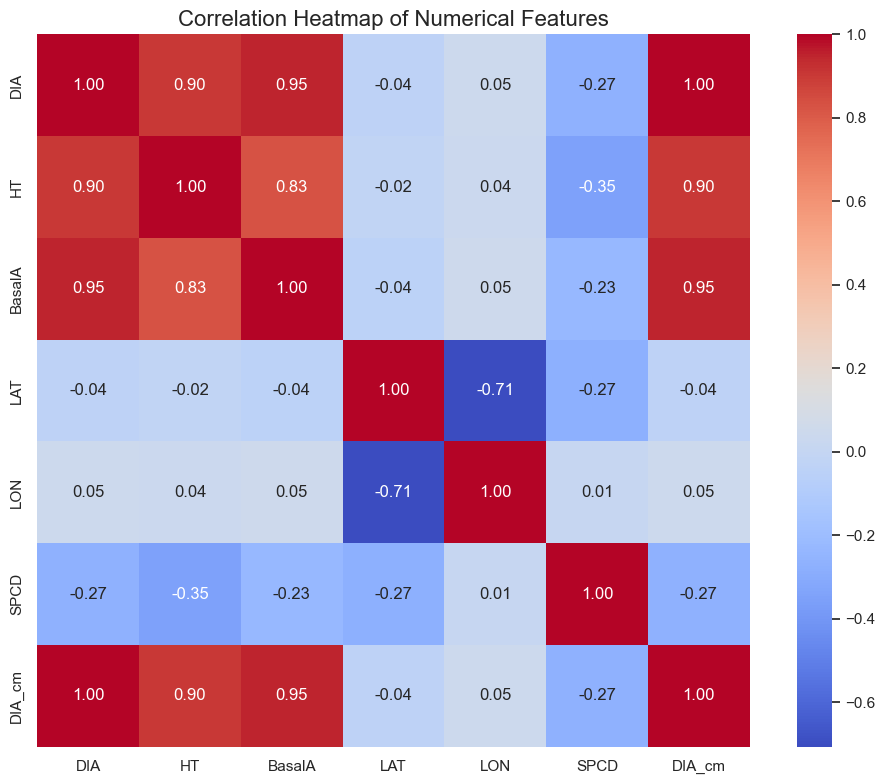

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/2836117344.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bool_sums.index, y=bool_sums.values, palette='pastel')


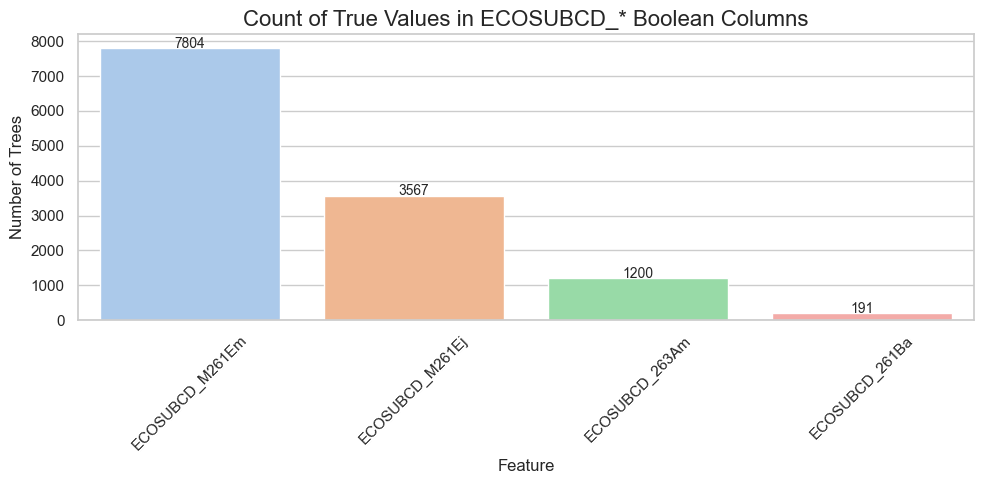

In [ ]:
df = df_encoded_fia.copy()

# ========== 1. Genus Distribution ==========
plt.figure(figsize=(12, 6))
ax = sns.countplot(y='GENUS', data=df, order=df['GENUS'].value_counts().index, palette='tab20')
plt.title('Distribution of Tree Genus', fontsize=16)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Genus', fontsize=12)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

# ========== 2. Tree Height vs Diameter by Genus ==========
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='DIA', y='HT', hue='GENUS', alpha=0.6, palette='tab10')
plt.title('Tree Height vs Diameter by Genus', fontsize=16)
plt.xlabel('Diameter (inches)', fontsize=12)
plt.ylabel('Height (feet)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Genus')
plt.tight_layout()
plt.show()

# ========== 3. Geospatial Tree Density ==========
plt.figure(figsize=(10, 6))
# KDE plot with tree density
kde = sns.kdeplot(
    data=df, x='LON', y='LAT', fill=True, cmap='viridis', thresh=0.05, levels=100
)
# Add colorbar manually
mappable = kde.get_children()[0]
cbar = plt.colorbar(mappable, ax=kde, orientation='vertical')
cbar.set_label('Density Estimate', fontsize=12)

plt.title('Tree Density by Geolocation', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ========== 4. Top ECOSUBCD Regions ==========
if 'ECOSUBCD' in df.columns:
    top_ecos = df['ECOSUBCD'].value_counts().head(10)
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=top_ecos.values, y=top_ecos.index, palette='coolwarm')
    plt.title('Top 10 ECOSUBCD Regions by Tree Count', fontsize=16)
    plt.xlabel('Number of Trees', fontsize=12)
    plt.ylabel('ECOSUBCD', fontsize=12)
    for i, v in enumerate(top_ecos.values):
        ax.text(v + 10, i, str(v), color='black', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

# ========== 5. Correlation Heatmap ==========
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# ========== 6. ECOSUBCD_* Boolean Flags ==========
bool_features = [col for col in df.columns if col.startswith('ECOSUBCD_') and df[col].dtype == bool]
if bool_features:
    bool_sums = df[bool_features].sum().sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=bool_sums.index, y=bool_sums.values, palette='pastel')
    plt.title('Count of True Values in ECOSUBCD_* Boolean Columns', fontsize=16)
    plt.ylabel('Number of Trees', fontsize=12)
    plt.xlabel('Feature', fontsize=12)
    for i, v in enumerate(bool_sums.values):
        ax.text(i, v + 10, str(v), ha='center', fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/991253373.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='PFT', palette='Set2')


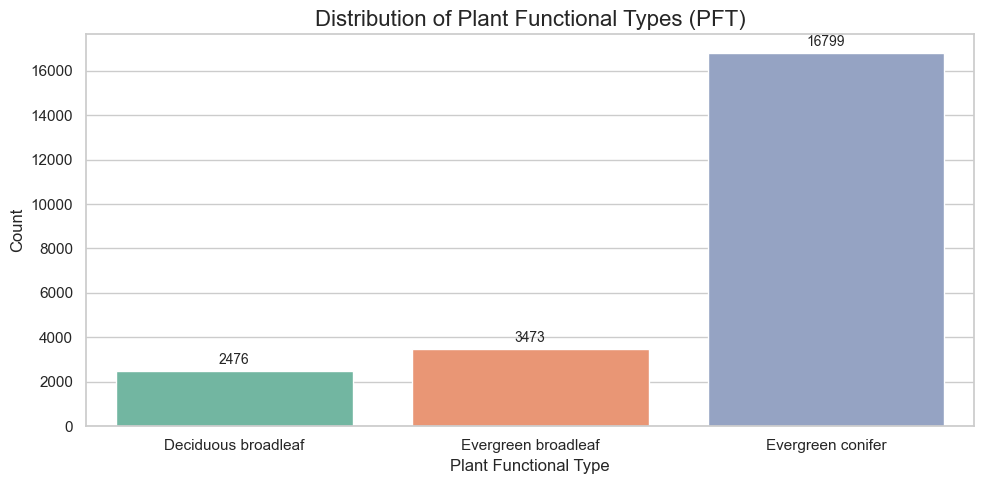

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/991253373.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_species.index, x=top_species.values, palette='Set3')


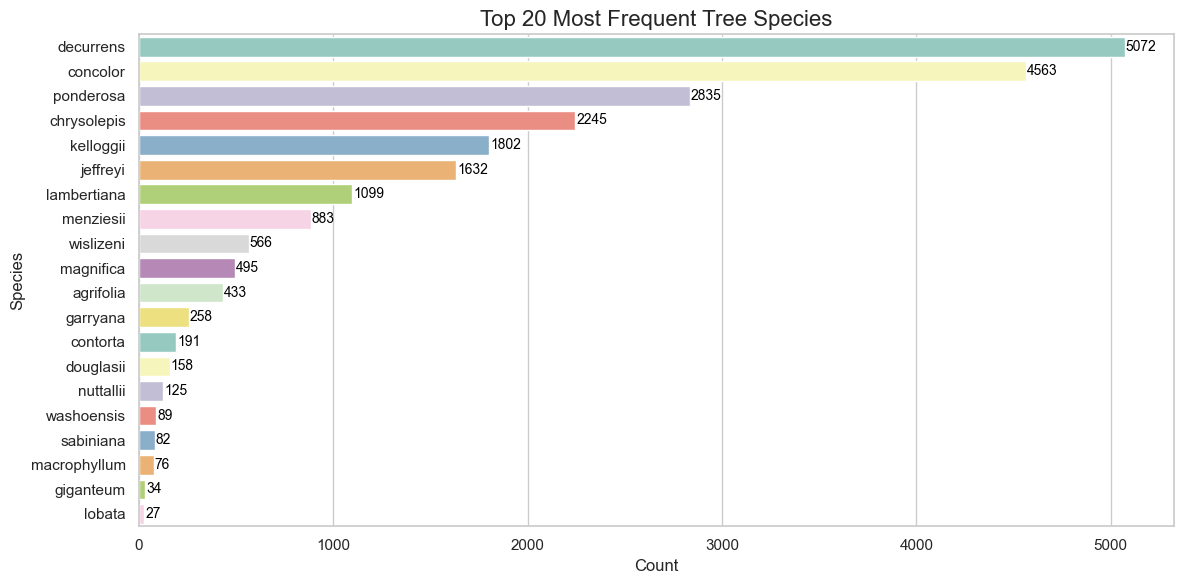

In [ ]:
# PFT Distribution
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='PFT', palette='Set2')
plt.title("Distribution of Plant Functional Types (PFT)", fontsize=16)
plt.xlabel("Plant Functional Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

# Top 20 Species Distribution
top_species = df['SPECIES'].value_counts().head(20)

plt.figure(figsize=(12, 6))
ax = sns.barplot(y=top_species.index, x=top_species.values, palette='Set3')
plt.title("Top 20 Most Frequent Tree Species", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Species", fontsize=12)
for i, v in enumerate(top_species.values):
    ax.text(v + 5, i, str(v), color='black', va='center', fontsize=10)
plt.tight_layout()
plt.show()


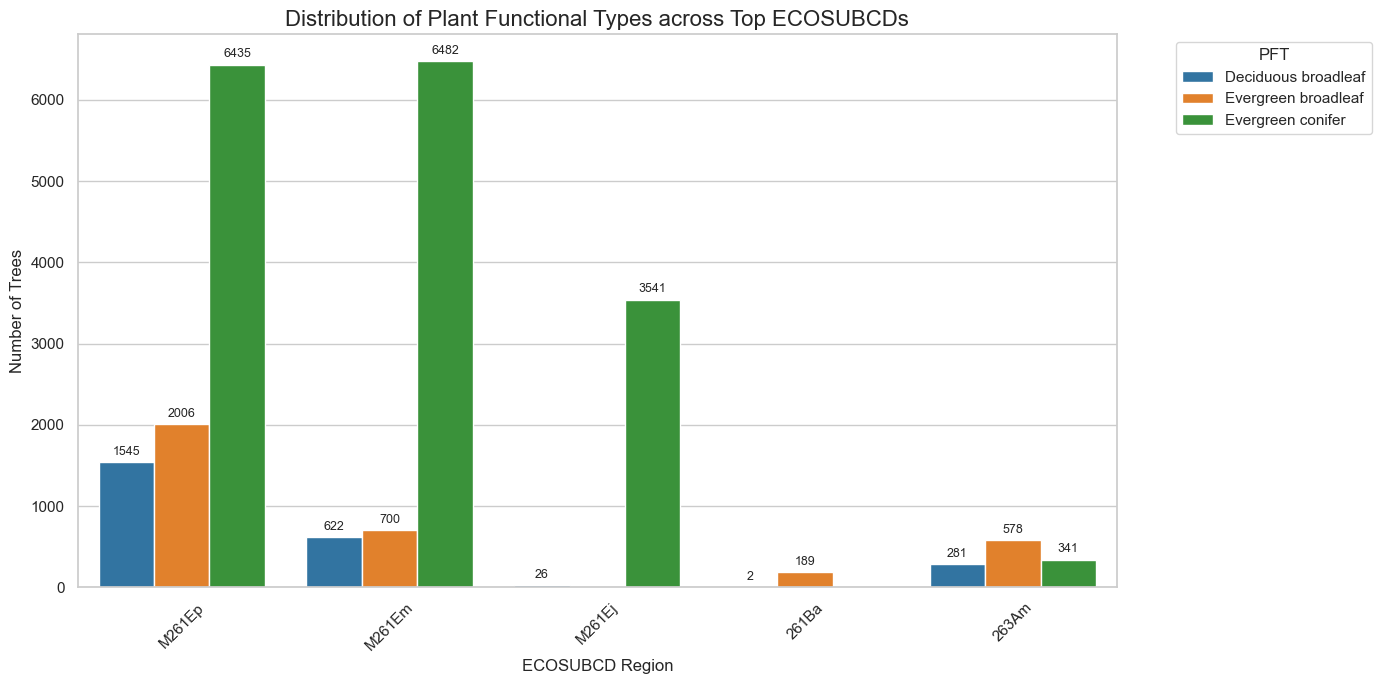

In [ ]:

# Select top ECOSUBCDs
top_ecosubcds = df['ECOSUBCD'].value_counts().head(10).index
df_top_ecos = df[df['ECOSUBCD'].isin(top_ecosubcds)]

# Create the count plot
plt.figure(figsize=(14, 7))
ax = sns.countplot(data=df_top_ecos, x='ECOSUBCD', hue='PFT', palette='tab10')

# Add count labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, padding=3)

plt.title('Distribution of Plant Functional Types across Top ECOSUBCDs', fontsize=16)
plt.xlabel('ECOSUBCD Region', fontsize=12)
plt.ylabel('Number of Trees', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='PFT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
list(df_fia_tree.columns)

['CN',
 'PLT_CN',
 'PREV_TRE_CN',
 'INVYR',
 'STATECD',
 'UNITCD',
 'COUNTYCD',
 'PLOT',
 'SUBP',
 'TREE',
 'CONDID',
 'PREVCOND',
 'STATUSCD',
 'SPCD',
 'SPGRPCD',
 'DIA',
 'DIAHTCD',
 'HT',
 'HTCD',
 'ACTUALHT',
 'TREECLCD',
 'CR',
 'CCLCD',
 'TREEGRCD',
 'AGENTCD',
 'CULL',
 'DAMLOC1',
 'DAMTYP1',
 'DAMSEV1',
 'DAMLOC2',
 'DAMTYP2',
 'DAMSEV2',
 'DECAYCD',
 'STOCKING',
 'WDLDSTEM',
 'VOLCFNET',
 'VOLCFGRS',
 'VOLCSNET',
 'VOLCSGRS',
 'VOLBFNET',
 'VOLBFGRS',
 'VOLCFSND',
 'DIACHECK',
 'MORTYR',
 'SALVCD',
 'UNCRCD',
 'CPOSCD',
 'CLIGHTCD',
 'CVIGORCD',
 'CDENCD',
 'CDIEBKCD',
 'TRANSCD',
 'TREEHISTCD',
 'BHAGE',
 'TOTAGE',
 'CULLDEAD',
 'CULLFORM',
 'CULLMSTOP',
 'CULLBF',
 'CULLCF',
 'BFSND',
 'CFSND',
 'SAWHT',
 'BOLEHT',
 'FORMCL',
 'HTCALC',
 'HRDWD_CLUMP_CD',
 'SITREE',
 'CREATED_DATE',
 'MODIFIED_DATE',
 'MORTCD',
 'HTDMP',
 'ROUGHCULL',
 'MIST_CL_CD',
 'CULL_FLD',
 'RECONCILECD',
 'PREVDIA',
 'P2A_GRM_FLG',
 'TREECLCD_NERS',
 'TREECLCD_SRS',
 'TREECLCD_NCRS',
 'TREECLCD_RMRS'

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/1229812280.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.index[:150], y=missing.values[:150], palette='rocket')


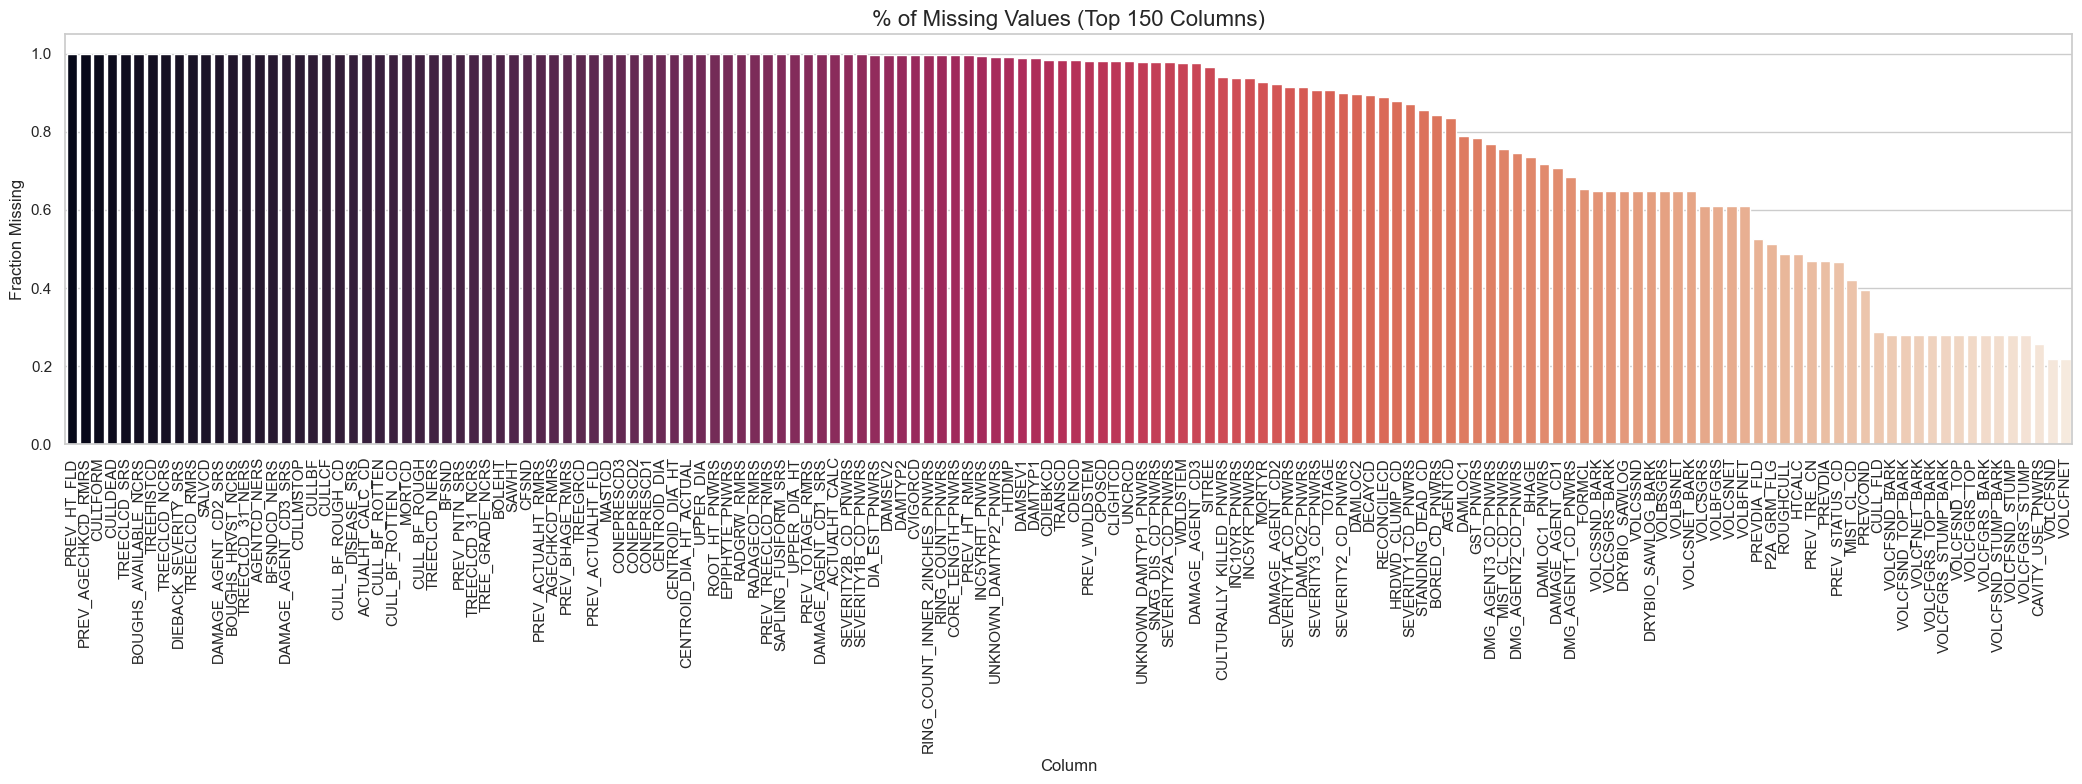

In [ ]:
df = df_fia_tree.copy()
# ========== 1. % of Missing Values ==========
missing = df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0]

plt.figure(figsize=(21, 8))
sns.barplot(x=missing.index[:150], y=missing.values[:150], palette='rocket')
plt.xticks(rotation=90)
plt.title('% of Missing Values (Top 150 Columns)', fontsize=16)
plt.ylabel('Fraction Missing')
plt.xlabel('Column')
plt.tight_layout()
plt.show()

# Drop above 150 columsn 
df = df.drop(missing.index[:150], axis=1)



📊 Key Observations:
Highly Correlated Feature Blocks (Red Clusters):
CN, PLT_CN, INVYR, CYCLE, PLOT form a tightly correlated group:
These are often identifier fields or metadata (plot numbers, inventory cycle, etc.)
High correlation (|r| ≈ 0.9–1.0) suggests they carry duplicate structural information
✅ You can safely drop most of these, keeping only the most interpretable/needed one
SPCD and SPGRPCD:
Species code and species group code are highly related (r ≈ 0.9)
✅ For tree-based models, keeping only one of them is typically sufficient
(e.g., use SPGRPCD if you want to reduce granularity)
Weakly or Uncorrelated Features:
Features like TREE, SUBP, CONDID, STATUSCD, UNITCD, COUNTYCD show low correlation with other variables
These are mostly structural or administrative identifiers, not meaningful for biological or ecological modeling
✅ Can be excluded from model input unless you need them for grouping or aggregation

# TLS

In [28]:
tls_df= pd.read_csv('./TLS_X_Genus.csv', low_memory=False)

In [29]:
tls_df.columns

Index(['DIA', 'HT', 'LAT', 'LON', 'ECOSUBCD_261Ba', 'ECOSUBCD_263Am',
       'ECOSUBCD_M261Ej', 'ECOSUBCD_M261Em', 'PFT_Deciduous broadleaf',
       'PFT_Evergreen broadleaf', 'PFT_Evergreen conifer', 'predicted_genus'],
      dtype='object')

In [30]:
tls_df

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,predicted_genus
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,Quercus
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,Quercus
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,Quercus
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,Pinus
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,Quercus
...,...,...,...,...,...,...,...,...,...,...,...,...
1281,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True,Abies
1282,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True,Calocedrus
1283,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True,Abies
1284,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True,Pinus


In [31]:
tls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   DIA                      1286 non-null   float64
 1   HT                       1286 non-null   float64
 2   LAT                      1286 non-null   float64
 3   LON                      1286 non-null   float64
 4   ECOSUBCD_261Ba           1286 non-null   bool   
 5   ECOSUBCD_263Am           1286 non-null   bool   
 6   ECOSUBCD_M261Ej          1286 non-null   bool   
 7   ECOSUBCD_M261Em          1286 non-null   bool   
 8   PFT_Deciduous broadleaf  1286 non-null   bool   
 9   PFT_Evergreen broadleaf  1286 non-null   bool   
 10  PFT_Evergreen conifer    1286 non-null   bool   
 11  predicted_genus          1286 non-null   object 
dtypes: bool(7), float64(4), object(1)
memory usage: 59.2+ KB


/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/3885955172.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=tls_df, y='predicted_genus', order=tls_df['predicted_genus'].value_counts().index, palette='tab20')


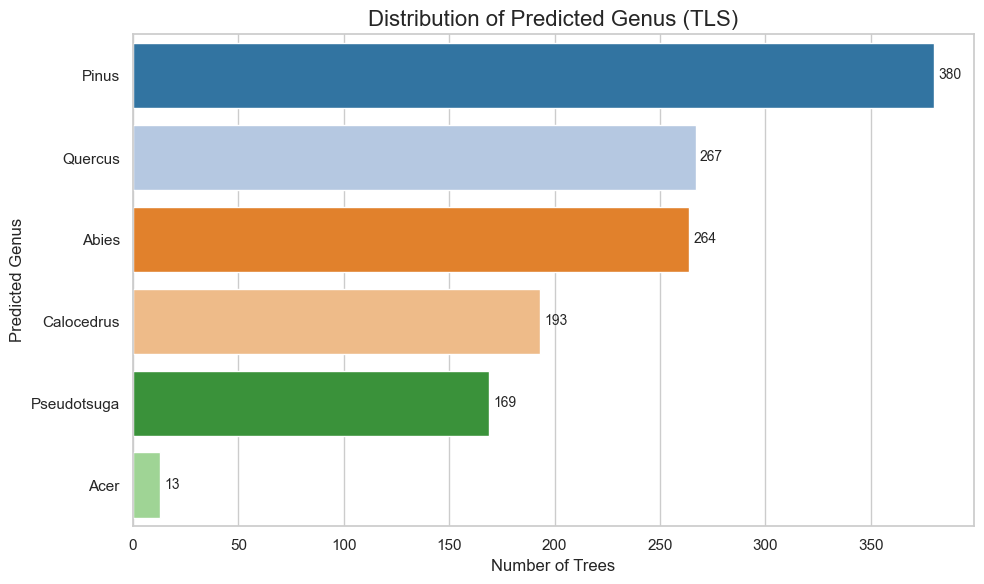

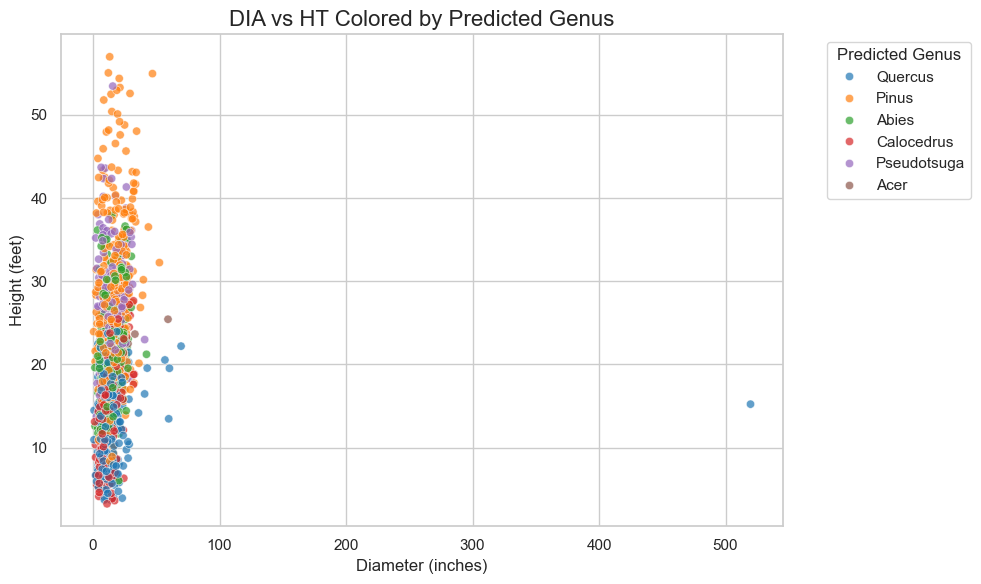

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/3885955172.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=pft_counts.index, y=pft_counts.values, palette='Set2')


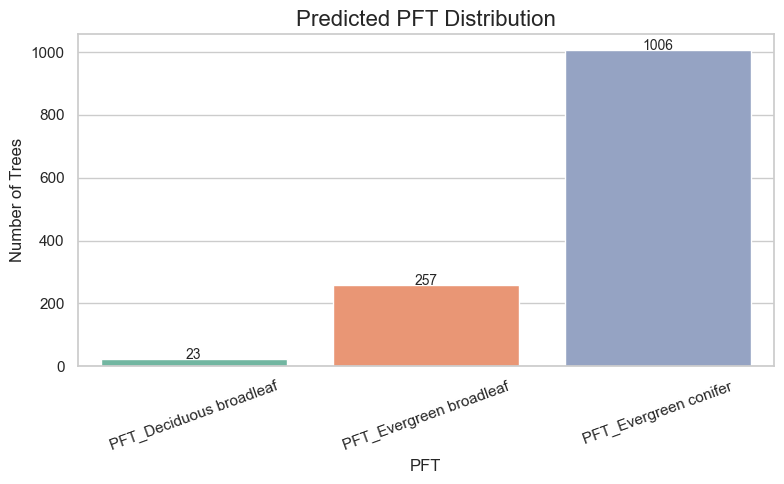

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/3885955172.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=eco_counts.index, y=eco_counts.values, palette='pastel')


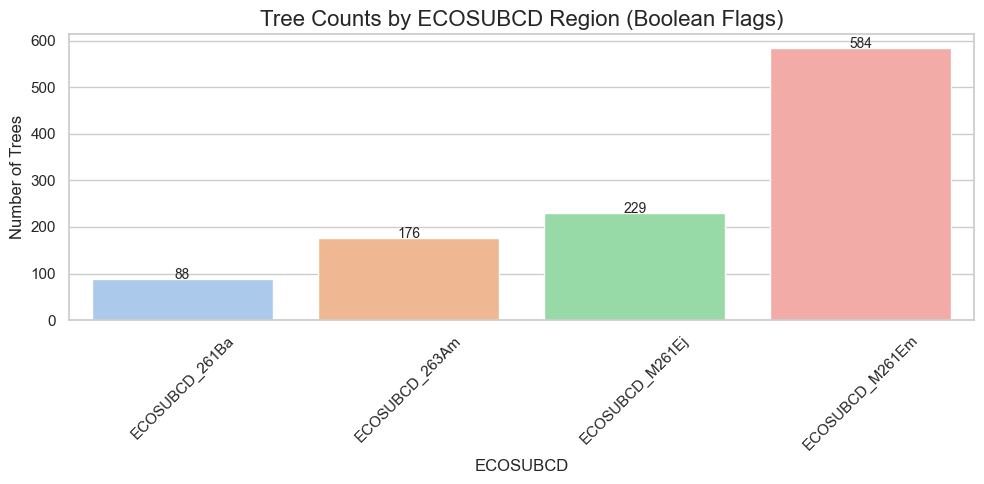

In [ ]:
# Ensure numeric columns are converted from object
numeric_cols = ['DIA', 'HT', 'LAT', 'LON']
tls_df[numeric_cols] = tls_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 1. Distribution of Predicted Genus
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=tls_df, y='predicted_genus', order=tls_df['predicted_genus'].value_counts().index, palette='tab20')
plt.title("Distribution of Predicted Genus (TLS)", fontsize=16)
plt.xlabel("Number of Trees")
plt.ylabel("Predicted Genus")
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=10)
plt.tight_layout()
plt.show()

# 2. DIA vs HT colored by predicted genus
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tls_df, x='DIA', y='HT', hue='predicted_genus', palette='tab10', alpha=0.7)
plt.title("DIA vs HT Colored by Predicted Genus", fontsize=16)
plt.xlabel("Diameter (inches)")
plt.ylabel("Height (feet)")
plt.legend(title='Predicted Genus', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Predicted PFT composition
pft_cols = [col for col in tls_df.columns if col.startswith("PFT_")]
pft_counts = tls_df[pft_cols].apply(pd.to_numeric, errors='coerce').sum()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=pft_counts.index, y=pft_counts.values, palette='Set2')
plt.title("Predicted PFT Distribution", fontsize=16)
plt.ylabel("Number of Trees")
plt.xlabel("PFT")
for i, v in enumerate(pft_counts.values):
    ax.text(i, v + 1, int(v), ha='center', fontsize=10)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


# 4. ECOSUBCD region counts
eco_cols = [col for col in tls_df.columns if col.startswith("ECOSUBCD_")]
eco_counts = tls_df[eco_cols].apply(pd.to_numeric, errors='coerce').sum()

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=eco_counts.index, y=eco_counts.values, palette='pastel')
plt.title("Tree Counts by ECOSUBCD Region (Boolean Flags)", fontsize=16)
plt.ylabel("Number of Trees")
plt.xlabel("ECOSUBCD")
for i, v in enumerate(eco_counts.values):
    ax.text(i, v + 1, int(v), ha='center', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


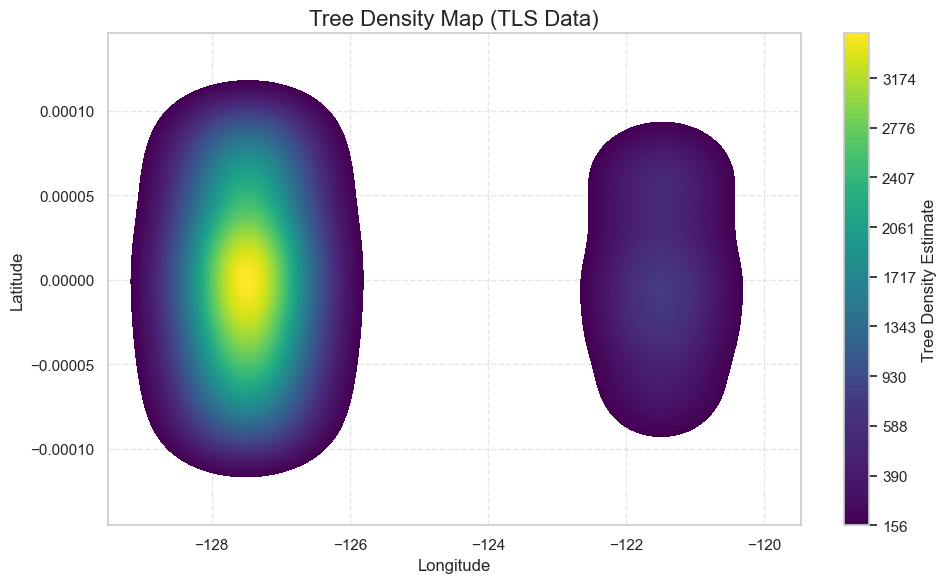

In [ ]:
# Make sure LAT and LON are numeric and drop NaNs
tls_df['LAT'] = pd.to_numeric(tls_df['LAT'], errors='coerce')
tls_df['LON'] = pd.to_numeric(tls_df['LON'], errors='coerce')
geo_data = tls_df.dropna(subset=['LAT', 'LON'])

# Create KDE plot
plt.figure(figsize=(10, 6))
kde_plot = sns.kdeplot(
    data=geo_data,
    x='LON',
    y='LAT',
    cmap='viridis',
    fill=True,
    levels=100,
    thresh=0.05
)

# Add colorbar manually from the first QuadContourSet
mappable = kde_plot.get_children()[0]
cbar = plt.colorbar(mappable, ax=kde_plot)
cbar.set_label('Tree Density Estimate', fontsize=12)

# Plot annotations
plt.title('Tree Density Map (TLS Data)', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Field - Ground Truth

In [34]:
df_field = pd.read_csv("./Field/03_tree.csv")
df_field_plot = pd.read_csv("./Field/01_plot_identification.csv")

print(df_field.shape)
print(df_field_plot.shape)
field_names = set(df_field['tree_sp_scientific_name'].value_counts().index)
fia_names = set(df_fia_species['SCI_NAME'].value_counts().index)
difference = list(field_names - fia_names)
difference
replace_dict = {'Salix spp.': 'Salix sp.', 'Quercus spp.': 'Quercus sp.', 'Cornus nuttallii': 'Cornus nuttalii'} 
df_fia_species['SCI_NAME'] = df_fia_species['SCI_NAME'].replace(replace_dict)
df_field = df_field.merge(df_field_plot, on="inventory_id", how="left")
df_field.head()
df_field.shape
df_field = df_field.merge(df_fia_species, left_on="tree_sp_scientific_name", right_on="SCI_NAME", how="left")
df_field.shape
# Replacing Deciduous with Deciduous broadleaf as both are the same
replace_dict = {'Deciduous': 'Deciduous broadleaf'} 
df_field['PFT'] = df_field['PFT'].replace(replace_dict)
df_field[df_field['tree_sp_scientific_name'] == 'Notholicarpos densiflorus']['PFT'] = 'Evergreen broadleaf'
# Calculate value counts as percentages
percentages = df_field['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)
# Define your mapping
site_to_ecosubcd = {
    "Shaver Lake (SHA)": "M261Ep",
    "Sedgwick Reserve (SDR)": "261Ba",
    "Calaveras Big Trees State Park": "M261Em",
    "Pacific Union College (PUC)": "263Am",
    "Independence Lake (IND)": "M261Ej",
    "Winton-Schaads VMP (WIN)" :"M261Em",
}

# Create new column
df_field['ECOSUBCD'] = df_field['site_name_label'].map(site_to_ecosubcd)
df_field['ECOSUBCD'].value_counts()

# print(df_field[['site_name_label', 'ECOSUBCD', 'LAT', 'LON']].head())
# Calculate value counts as percentages
percentages = df_field.groupby('ECOSUBCD')['PFT'].value_counts(normalize=True) * 100

# Round and display
percentages = percentages.round(2)
print(percentages)

df_field[['GENUS', 'SPECIES']] = df_field['tree_sp_scientific_name'].str.split(' ', n=1, expand=True)
df_field.head()

(2147, 22)
(163, 61)
PFT
Evergreen conifer      69.82
Evergreen broadleaf    21.43
Deciduous broadleaf     8.71
Tree                    0.05
Name: proportion, dtype: float64
ECOSUBCD  PFT                
261Ba     Evergreen broadleaf    84.07
          Deciduous broadleaf    15.93
263Am     Evergreen broadleaf    50.95
          Evergreen conifer      40.68
          Deciduous broadleaf     8.37
M261Ej    Evergreen conifer      93.58
          Deciduous broadleaf     6.42
M261Em    Evergreen conifer      89.31
          Deciduous broadleaf     8.11
          Evergreen broadleaf     2.46
          Tree                    0.12
M261Ep    Evergreen conifer      94.83
          Deciduous broadleaf     5.17
Name: proportion, dtype: float64


/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/452170128.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_field[df_field['tree_sp_scientific_name'] == 'Notholicarpos densiflorus']['PFT'] = 'Evergreen broadleaf'


,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,MAJGRP,OCC.NC,OCC.NE,OCC.PNW,OCC.RM,OCC.SO,PFT,ECOSUBCD,GENUS,SPECIES
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor


In [35]:
df_field 

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,MAJGRP,OCC.NC,OCC.NE,OCC.PNW,OCC.RM,OCC.SO,PFT,ECOSUBCD,GENUS,SPECIES
0,143_pre_SHA_burn3d,1,204,ABCO,Abies concolor,NaN,Live,Live,8.2,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
1,143_pre_SHA_burn3d,2,205,ABCO,Abies concolor,NaN,Live,Live,54.6,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
2,143_pre_SHA_burn3d,3,206,ABCO,Abies concolor,NaN,Live,Live,86.9,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
3,143_pre_SHA_burn3d,4,207,ABCO,Abies concolor,NaN,Live,Live,21.7,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
4,143_pre_SHA_burn3d,5,208,ABCO,Abies concolor,NaN,Live,Live,45.3,NaN,...,2,X,-,X,X,X,Evergreen conifer,M261Ep,Abies,concolor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,46_pre_puc_burn3d,11,1155,NODE,Notholicarpos densiflorus,NaN,Live,Live,35.6,NaN,...,3,X,X,X,-,X,Evergreen broadleaf,263Am,Notholicarpos,densiflorus
2143,46_pre_puc_burn3d,12,1156,NODE,Notholicarpos densiflorus,NaN,Live,Live,43.7,NaN,...,3,X,X,X,-,X,Evergreen broadleaf,263Am,Notholicarpos,densiflorus
2144,46_pre_puc_burn3d,13,1157,PSME,Pseudotsuga menziesii,NaN,Live,Live,71.4,NaN,...,2,X,X,X,X,X,Evergreen conifer,263Am,Pseudotsuga,menziesii
2145,46_pre_puc_burn3d,14,1158,ARBMEN,Arbutus menziesii,NaN,Live,Live,31.9,NaN,...,4,-,-,X,X,-,Evergreen broadleaf,263Am,Arbutus,menziesii


/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/1964068903.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_species.index, x=top_species.values, palette='viridis')


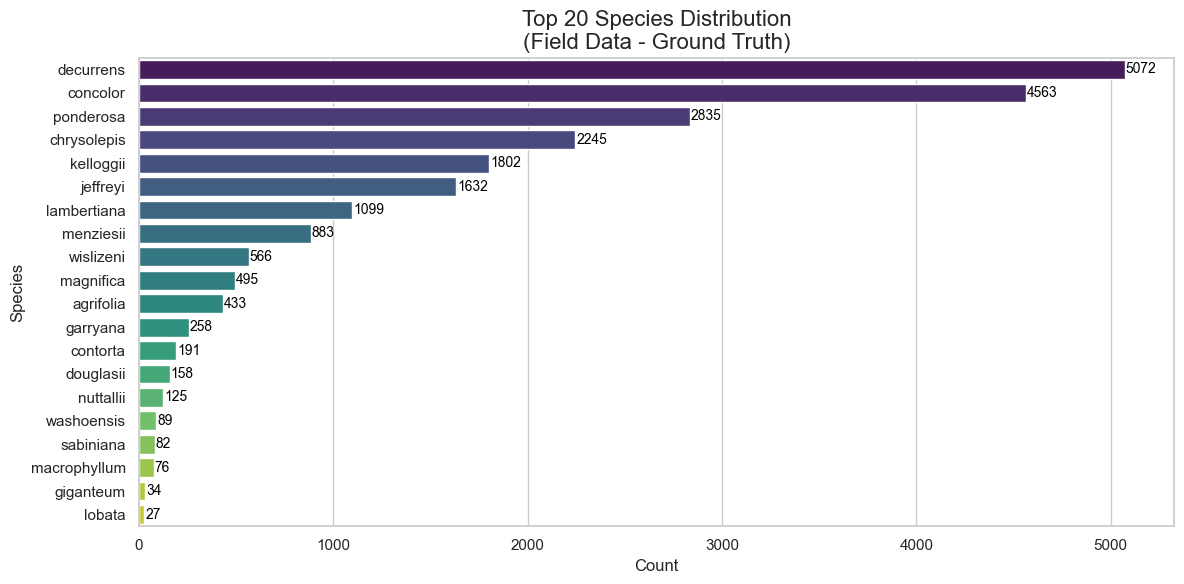

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/1964068903.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=top_genus.index, x=top_genus.values, palette='coolwarm')


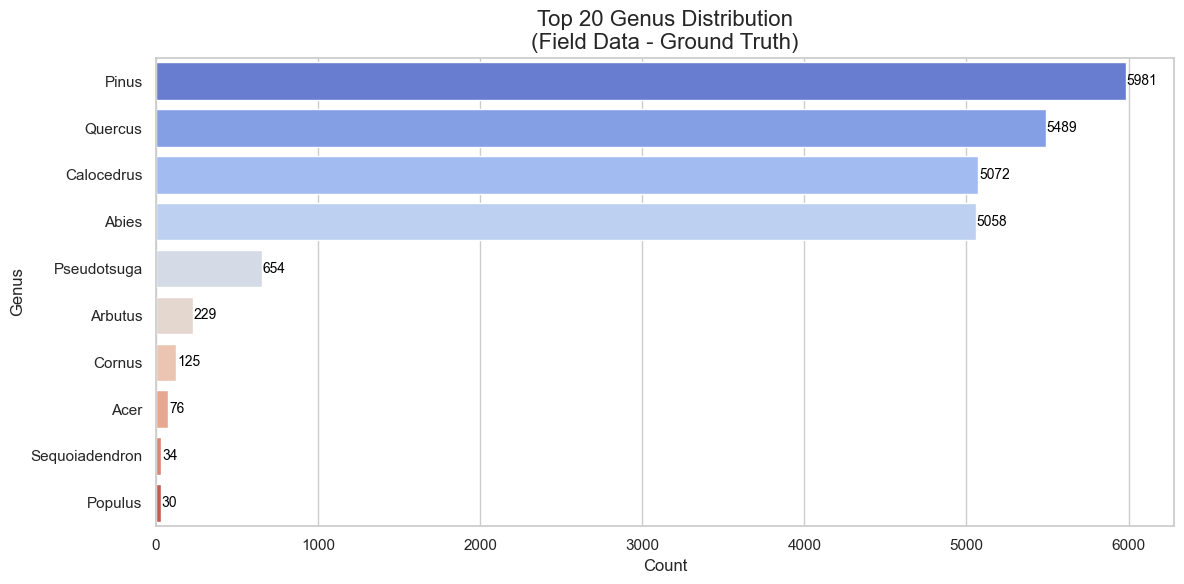

/var/folders/r_/3zpp4z8x0jsdx29mzsxh1c_80000gn/T/ipykernel_86575/1964068903.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_encoded_fia, x='PFT', palette='Set2', order=order)


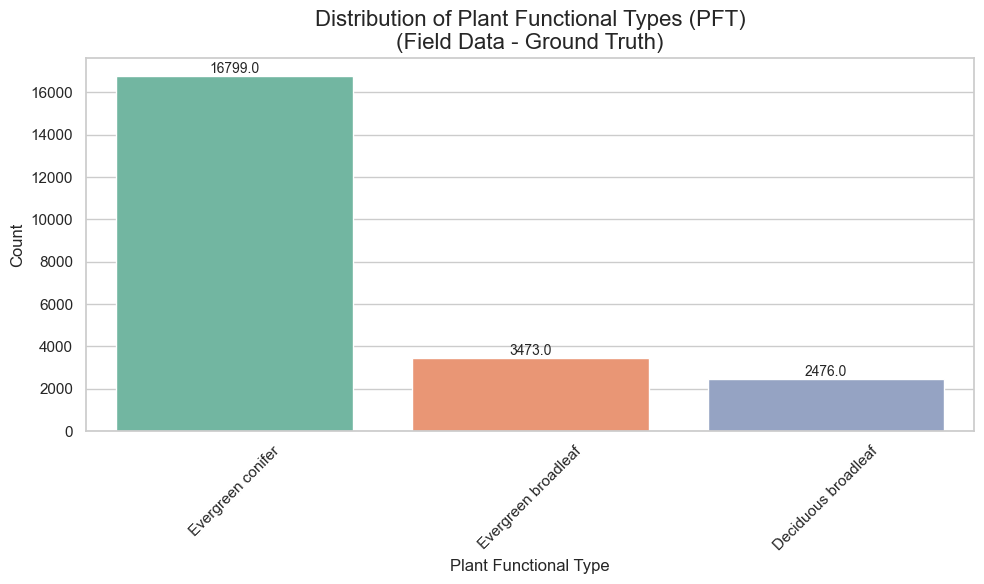

In [ ]:
# --- Species Distribution ---
plt.figure(figsize=(12, 6))
top_species = df_encoded_fia['SPECIES'].value_counts().head(20)
ax = sns.barplot(y=top_species.index, x=top_species.values, palette='viridis')
plt.title('Top 20 Species Distribution\n(Field Data - Ground Truth)', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Species', fontsize=12)

# Add numeric labels
for i, v in enumerate(top_species.values):
    ax.text(v + 5, i, str(v), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# --- Genus Distribution ---
plt.figure(figsize=(12, 6))
top_genus = df_encoded_fia['GENUS'].value_counts().head(20)
ax = sns.barplot(y=top_genus.index, x=top_genus.values, palette='coolwarm')
plt.title('Top 20 Genus Distribution\n(Field Data - Ground Truth)', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genus', fontsize=12)

# Add numeric labels
for i, v in enumerate(top_genus.values):
    ax.text(v + 5, i, str(v), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# --- PFT Distribution ---
plt.figure(figsize=(10, 6))
order = df_encoded_fia['PFT'].value_counts().index
ax = sns.countplot(data=df_encoded_fia, x='PFT', palette='Set2', order=order)
plt.title('Distribution of Plant Functional Types (PFT)\n(Field Data - Ground Truth)', fontsize=16)
plt.xlabel('Plant Functional Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

# Add numeric labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


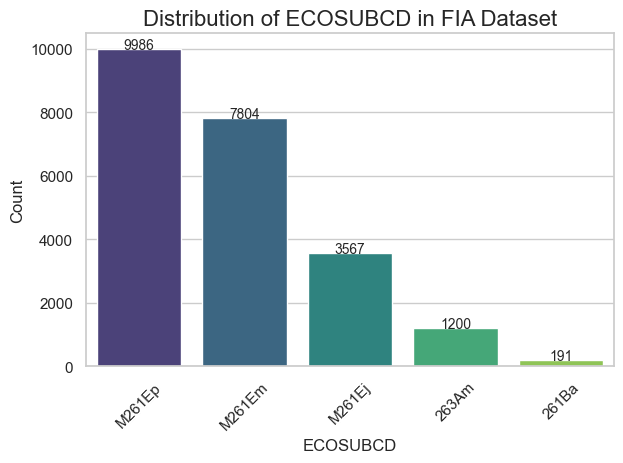

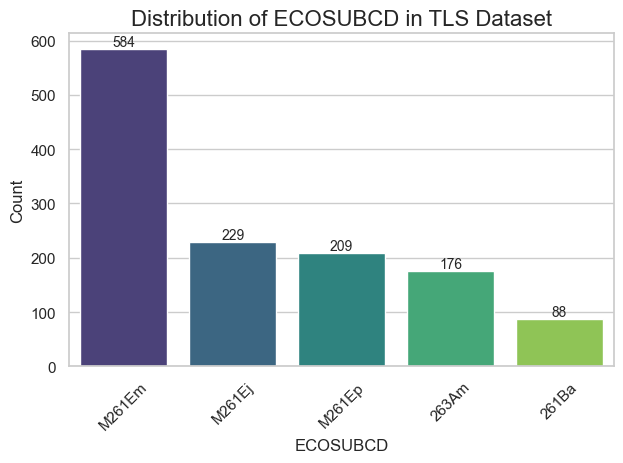

In [ ]:
"""# Define a function to plot ECOSUBCD distributions
def plot_ecosubcd_distribution(df, column_name, dataset_name):
    if column_name == 'ECOSUBCD' and 'ECOSUBCD_M261Ep' not in df.columns:
        # Handle one-hot encoded ECOSUBCD columns
        ecosubcd_columns = [col for col in df.columns if col.startswith('ECOSUBCD_')]
        df[column_name] = df[ecosubcd_columns].idxmax(axis=1).str.replace('ECOSUBCD_', '')
        df.loc[df[ecosubcd_columns].sum(axis=1) == 0, column_name] = 'M261Ep'
    value_counts = df[column_name].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='viridis')
    plt.title(f'Distribution of ECOSUBCD in {dataset_name}', fontsize=16)
    plt.xlabel('ECOSUBCD', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    for i, v in enumerate(value_counts.values):
        plt.text(i, v + 5, str(v), ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot ECOSUBCD distributions for each dataset
plot_ecosubcd_distribution(df_encoded_fia, 'ECOSUBCD', 'FIA Dataset')
plot_ecosubcd_distribution(tls_df, 'ECOSUBCD', 'TLS Dataset')
plot_ecosubcd_distribution(df_field, 'ECOSUBCD', 'Field Dataset')"""

In [44]:
df_encoded_fia

,DIA,HT,BasalA,LAT,LON,SPCD,PFT,DIA_cm,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,ECOSUBCD,GENUS,SPECIES,COMMON_NAME
0,6.1,25.0,0.202949,37.514660,-119.737508,81.0,Evergreen conifer,15.494,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
1,1.0,7.0,0.005454,38.153364,-120.059054,15.0,Evergreen conifer,2.540,False,False,False,True,M261Em,Abies,concolor,white fir
2,16.8,66.0,1.539380,37.075657,-119.382396,81.0,Evergreen conifer,42.672,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar
3,17.2,49.0,1.613557,38.605369,-120.371609,81.0,Evergreen conifer,43.688,False,False,False,True,M261Em,Calocedrus,decurrens,incense-cedar
4,7.8,40.0,0.331831,37.370380,-119.540933,117.0,Evergreen conifer,19.812,False,False,False,False,M261Ep,Pinus,lambertiana,sugar pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23718,15.1,93.0,1.243602,36.791094,-118.966081,15.0,Evergreen conifer,38.354,False,False,False,False,M261Ep,Abies,concolor,white fir
23719,17.6,57.0,1.689479,38.001863,-120.030085,122.0,Evergreen conifer,44.704,False,False,False,True,M261Em,Pinus,ponderosa,ponderosa pine
23720,7.2,28.0,0.282743,36.211111,-118.657481,818.0,Deciduous broadleaf,18.288,False,False,False,False,M261Ep,Quercus,kelloggii,California black oak
23721,2.0,10.0,0.021817,37.096947,-119.360283,81.0,Evergreen conifer,5.080,False,False,False,False,M261Ep,Calocedrus,decurrens,incense-cedar


In [45]:
tls_df

,DIA,HT,LAT,LON,ECOSUBCD_261Ba,ECOSUBCD_263Am,ECOSUBCD_M261Ej,ECOSUBCD_M261Em,PFT_Deciduous broadleaf,PFT_Evergreen broadleaf,PFT_Evergreen conifer,predicted_genus,ECOSUBCD
0,20.987379,12.560,0.000019,-121.488648,False,False,False,False,False,True,False,Quercus,M261Ep
1,13.105771,8.742,0.000010,-121.488722,False,False,False,False,False,True,False,Quercus,M261Ep
2,59.840890,13.469,0.000009,-121.488725,False,False,False,False,False,True,False,Quercus,M261Ep
3,21.040854,18.144,0.000079,-121.488726,False,False,False,False,False,False,True,Pinus,M261Ep
4,16.390056,13.790,0.000002,-121.488731,False,False,False,False,False,True,False,Quercus,M261Ep
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,17.323968,30.631,0.000025,-127.488832,False,False,False,True,False,False,True,Abies,M261Em
1282,24.252048,23.077,-0.000084,-127.488726,False,False,False,True,False,False,True,Calocedrus,M261Em
1283,17.835430,30.127,0.000062,-127.488817,False,False,False,True,False,False,True,Abies,M261Em
1284,14.208700,29.300,-0.000074,-127.488768,False,False,False,True,False,False,True,Pinus,M261Em


In [46]:
df_field["ECOSUBCD"].value_counts()

ECOSUBCD
M261Em    814
261Ba     364
M261Ej    358
M261Ep    348
263Am     263
Name: count, dtype: int64

In [47]:
df_encoded.columns

Index(['DIA', 'HT', 'BasalA', 'LAT', 'LON', 'SPCD', 'PFT', 'DIA_cm',
       'ECOSUBCD_261Ba', 'ECOSUBCD_263Am', 'ECOSUBCD_M261Ej',
       'ECOSUBCD_M261Em', 'ECOSUBCD'],
      dtype='object')

In [48]:
df = pd.read_csv('pft_tls.csv', low_memory=False)

In [49]:
df.columns

Index(['TreeID', 'X', 'Y', 'Radius', 'Error', 'H', 'h_radius', 'DBH', 'BasalA',
       'plot_blk', 'Unnamed: 0', 'inventory_id', 'site_project',
       'site_project_label', 'site_name', 'site_name_label',
       'inventory_pre_post_fire', 'inventory_pre_post_fire_label', 'plot_num',
       'inventory_date', 'inventory_hour', 'plot_coord_x', 'plot_coord_y',
       'plot_coord_srs', 'plot_declination', 'inventory_plot_diam',
       'plot_slopeper', 'plot_aspectdegre', 'LAT', 'LON', 'ECOSUBCD'],
      dtype='object')

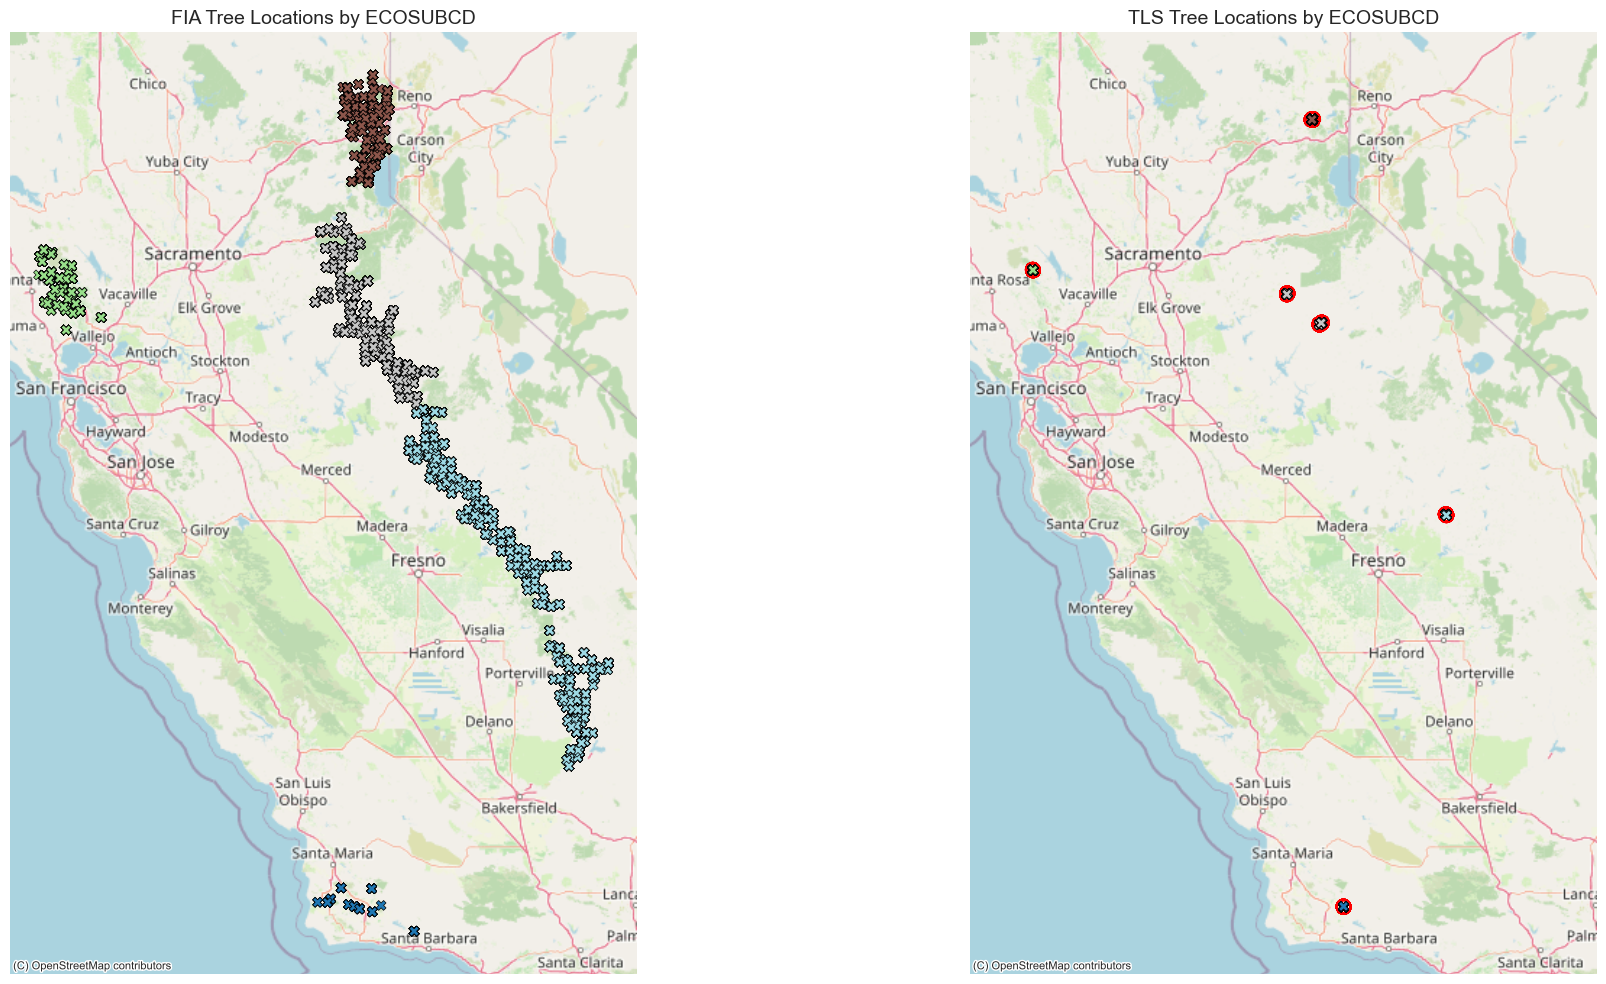

In [50]:
fia = df_encoded.copy()
geometry_fia = [Point(xy) for xy in zip(fia['LON'], fia['LAT'])]
gdf_fia = gpd.GeoDataFrame(fia, geometry=geometry_fia, crs="EPSG:4326").to_crs(epsg=3857)

tls = pd.read_csv('pft_tls.csv', low_memory=False).dropna(subset=["LAT", "LON"])
geometry_tls = [Point(xy) for xy in zip(tls['LON'], tls['LAT'])]
gdf_tls = gpd.GeoDataFrame(tls, geometry=geometry_tls, crs="EPSG:4326").to_crs(epsg=3857)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), sharex=True, sharey=True)

# --- FIA PLOT ---
gdf_fia.plot(
    ax=ax1,
    column='ECOSUBCD',
    cmap='tab20',
    legend=False,
    markersize=50,
    alpha=1.0,
    marker='X',
    edgecolor='black',
    linewidth=0.5,
    zorder=3
)
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_fia.crs.to_string(), zorder=1)
ax1.set_title("FIA Tree Locations by ECOSUBCD", fontsize=14)
ax1.set_axis_off()

# --- TLS PLOT ---
# Red circles underlay
gdf_tls.plot(
    ax=ax2,
    color='none',
    edgecolor='red',
    linewidth=1.2,
    markersize=100,
    marker='o',
    zorder=2,
    alpha=0.8
)
# X overlay
gdf_tls.plot(
    ax=ax2,
    column='ECOSUBCD',
    cmap='tab20',
    legend=False,
    markersize=50,
    marker='X',
    edgecolor='black',
    linewidth=0.5,
    alpha=1.0,
    zorder=3
)
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_tls.crs.to_string(), zorder=1)
ax2.set_title("TLS Tree Locations by ECOSUBCD", fontsize=14)
ax2.set_axis_off()

# Final layout
plt.tight_layout()
plt.show()
